### Step 1: Import the libraries

In [11]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import random
import json
import requests
import warnings
warnings.filterwarnings(action="ignore") # Ignore pandas warnings
import logging
logging.basicConfig(
    level="INFO",
    filename="pytrends_script_logs.log",
    datefmt="%Y-%m-%d %H-%M-%S",
    format="%(asctime)s - %(levelname)s - %(message)s",
)

### Step 2.1: Set the global inputs

In [12]:
# Set search parameters
# Please make sure that the first keywords in the JSON file actually has a response from the Pytrends API. By default, I included the keyword "Drama", so please don't remove it
# Max recommended keywords per code run and IP address are: 2400 (or 600 chunks)
with open("keywords.json", mode="r", encoding="utf-8") as f:
    keywords = json.load(f)
    f.close()
category = 18 # Shopping category
geo = 'US'
hl = "en-US" # # The parameter hl specifies host language for accessing Google Trends
tz_offset = 360 # Timezone offset. For example US CST is '360'
timeframe = 'today 3-m' # Past 90 days
score_threshold = 50
filtered_kw_last_score_threshold = 35
min_days_above_threshold = 45 # Minimum number of days where score >= 50
window_size = 30 # Window size for calculating the rolling average

### Step 2.2: Do some data processing before pulling the Google Trends data

In [13]:
# Eliminate the duplicates from the keywords list to prevent the appearance of duplicate charts in the last step
keywords_non_dup = list(dict.fromkeys(keywords))

# Create a chunked list to speed up the processing of keywords. Each chunk should consist of 5 items
# Because we are comparing more than 5 keywords to each other, each request should contain one normalized category because the Google API returns normalized numbers in the 0-100 range
# The anchor keyword for each chunk will be the first word of the list, and it has to have a response from the API
def chunks(lst, n):
    """
    Yield successive n-sized chunks from a list
    """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

chunked_keywords = list(lst + [keywords_non_dup[0]] for lst in list(chunks(keywords_non_dup[1:], 4)))

### Step 3: Pull the Google Trends data

In [16]:
# Instantiate the TrendReq class
pytrends = TrendReq(
    hl=hl,
    tz=tz_offset,
    timeout=(10,25), # Connect and read timeout periods in seconds
    retries=3, # Number of retries total/connect/read, all represented by one number
    backoff_factor=0.1, # A backoff factor to apply between attempts after the second try
    requests_args={"verify": False} # A dict with additional parameters to pass along to the underlying requests library. Veriy = False ignores SSL errors
)

# logging.info a status message, showing the number of keywords and batches we will loop through
logging.info(f"In total, we have {len(keywords_non_dup)} keywords and {len(chunked_keywords)} batches to loop through. The total run time is expected to be around {len(chunked_keywords) * 0.925} seconds")

df_interest = []
for idx, keyword in enumerate(chunked_keywords):
    # Build the pytrends payload for a batch of five keywords
    logging.info(f"Build the pytrends payload for this batch of keywords: {keyword}. This is batch {idx + 1} out of {len(chunked_keywords)}")
    pytrends.build_payload(
        kw_list=keyword,
        cat=category,
        geo=geo,
        timeframe=timeframe
    )

    # Create a dataframe showing the interest over time
    logging.info("Pulling the interest over time data")
    df_iter = pytrends.interest_over_time()
    
    # If this is NOT the first iteration, drop the anchor column from df_iter
    if idx > 0:
        df_iter.drop(keywords_non_dup[0], inplace=True, axis=1)
    
    logging.info("Append df_iter to df_interest\n")
    df_interest.append(df_iter)

    # Wait for a random number of seconds between requests
    time.sleep(random.uniform(0.5, 3))

# Convert df_interest from a list to a pandas data frame
df_interest = pd.concat(df_interest, axis=1)

# Drop the column isPartial
df_interest.drop("isPartial", inplace=True, axis=1)

### Step 4: Calculate the moving averages

In [18]:
# If df_interest is not empty, calculate the moving averages of each colum
if not df_interest.empty:
    keyword_scores = df_interest.apply(lambda x: x.rolling(window=min(window_size, x.notnull().sum()), min_periods=1).mean())

# Display the head of the keyword_scores data frame
keyword_scores.head()

,Filter Cases,Lens Cases,Telescope Cases,Tripod & Monopod Cases,Drama,Binoculars,Gun Scopes,Laser Rangefinders,Microscopes,Monoculars,...,Laboratory Medicine,Emergencies,Perinatology & Neonatology,Diagnostic Imaging,Nuclear Medicine,Ultrasonography,Dalai Lama,Mahayana,Rituals & Practice,Afro-Latino
date,,,,,,,,,,,,,,,,,,,,,
2023-02-20,0.0,0.0,18.000000,0.0,59.0,60.00,0.0,0.000000,4.000000,19.000000,...,0.0,21.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.00
2023-02-21,0.0,0.0,15.500000,0.0,38.5,58.00,0.0,2.500000,2.000000,9.500000,...,0.0,10.500000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.00
2023-02-22,0.0,0.0,10.333333,0.0,28.0,63.00,0.0,1.666667,1.333333,6.333333,...,0.0,10.666667,0.0,0.00,0.0,0.0,2.333333,0.0,0.0,3.00
2023-02-23,0.0,5.5,7.750000,0.0,28.5,59.25,0.0,2.250000,1.000000,4.750000,...,0.0,11.500000,0.0,2.75,2.0,0.0,1.750000,0.0,0.0,2.25
2023-02-24,0.0,6.6,6.200000,0.0,31.8,61.20,0.0,1.800000,0.800000,3.800000,...,1.6,9.200000,0.0,2.20,1.6,0.0,1.400000,3.0,0.0,1.80


### Step 5: Filter keywords based on the score criteria

In [19]:
if not keyword_scores.empty:
    # Retrieve the keywords where the moving averages exceeded the score threshold for at least "min_days_above_threshold" days
    filtered_keywords = keyword_scores.columns[(keyword_scores >= score_threshold).sum() >= min_days_above_threshold].tolist()
    
    # Assign a flag to the last scores of the filtered keywords. True if the last score is >= filtered_kw_last_score_threshold. Otherwise, False. Like filtered_keywords, this will also be a list
    filtered_keywords_last_score = list(keyword_scores[filtered_keywords].iloc[-1] >= filtered_kw_last_score_threshold)

    # Further trim down the filtered keywords list by searching for keywords where the "filtered_keywords_last_scores" is True
    filtered_keywords = [keyword for keyword, score in zip(filtered_keywords, filtered_keywords_last_score) if score]

    # Sort filtered keywords based on the rising slope of the rolling 30-day average from first to last value and save the sorted keywords to a list
    filtered_keywords_sorted_list = keyword_scores[filtered_keywords].diff().iloc[window_size-1:].mean().sort_values(ascending=False).index.tolist() ### CHECK
else:
    logging.info("No keywords found for the given parameters")

# Display the first 5 elements of the filtered keywords list
print(filtered_keywords_sorted_list[0:5])
print(f"The length of the sorted list of filtered keywords is: {len(filtered_keywords_sorted_list)}")

['Samba', 'Friendship', 'Drawing', 'Electric', 'Templates']
The length of the sorted list of filtered keywords is: 190


### Step 6: Plot the graphs for the filtered keywords

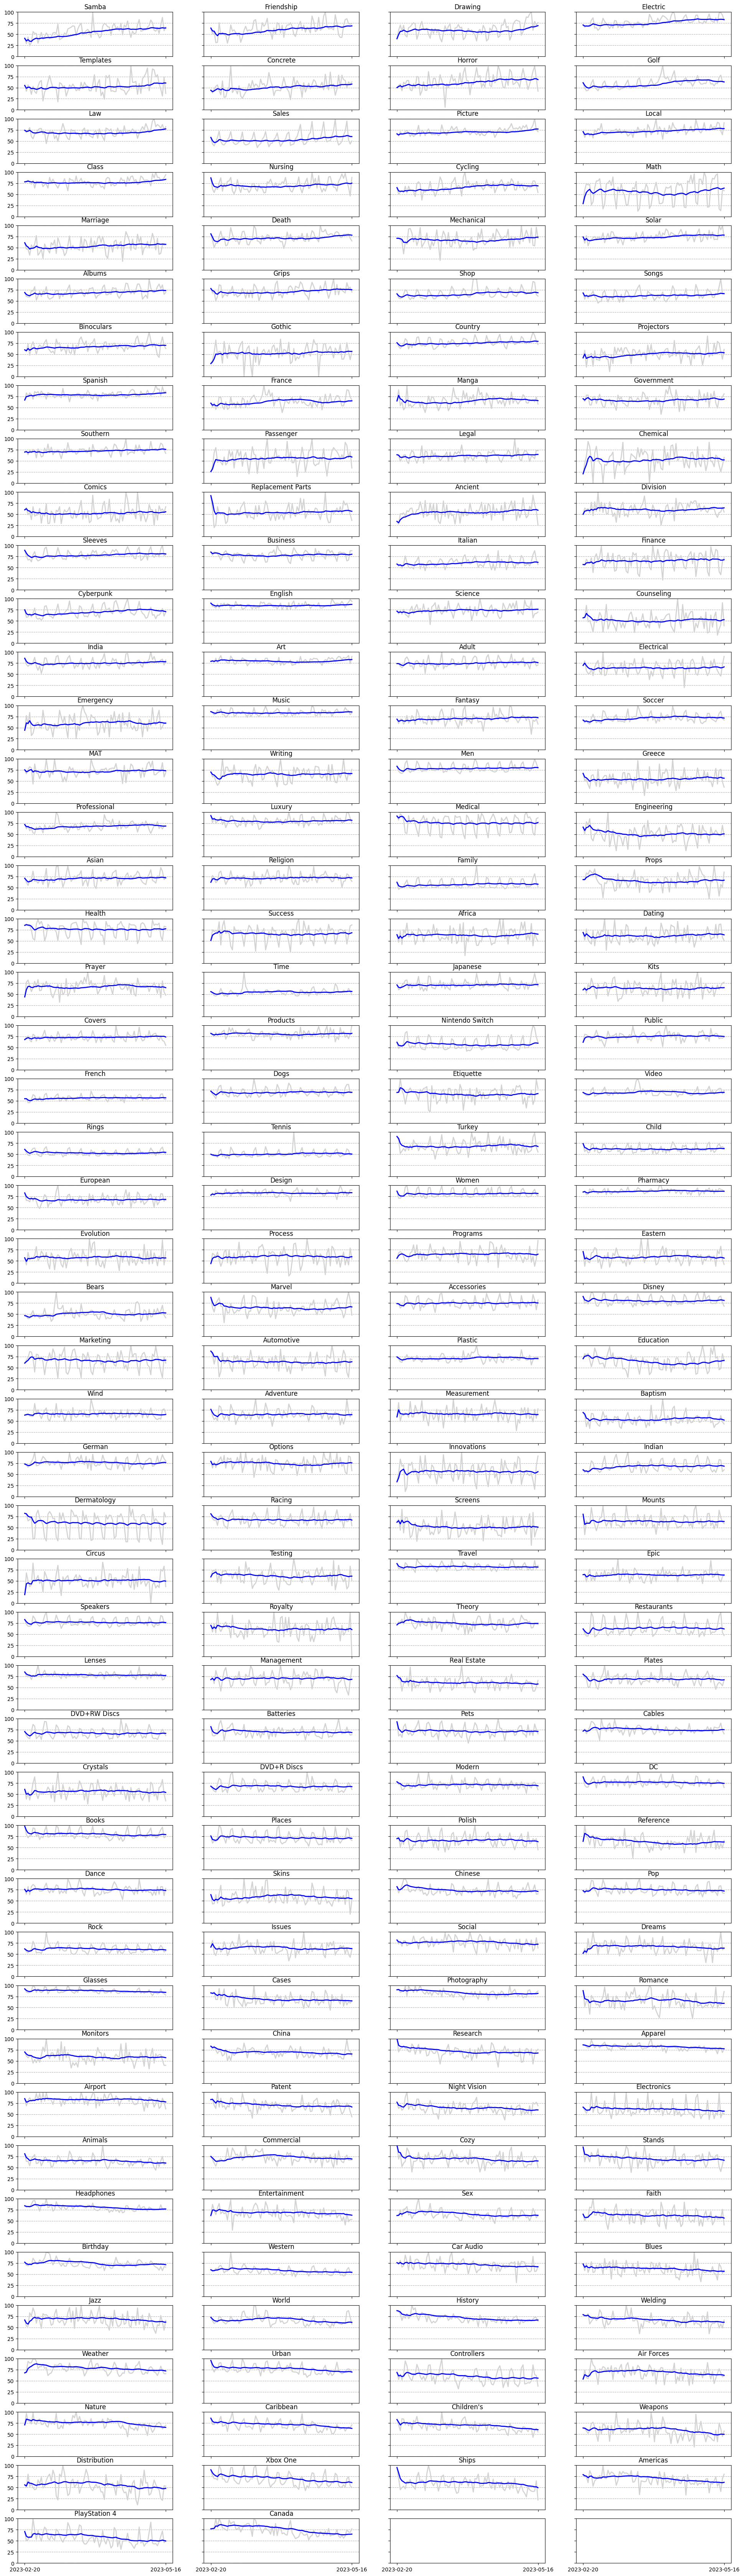

In [20]:
# Set some inputs for the graphs
num_plots = len(filtered_keywords_sorted_list)
num_rows = (num_plots + 3) // 4
fig, axs = plt.subplots(num_rows, 4, figsize=(24, num_rows * 1.8), sharex=True, sharey=True)

# Flatten the axs array into a 1D array
axs_flat = axs.flatten()

for idx, keyword in enumerate(filtered_keywords_sorted_list):
    if not df_interest.empty:
        # Add the raw data plot
        axs_flat[idx].plot(df_interest[keyword], color='lightgrey', linewidth=2, label='Raw Data')
        
        # Add the rolling 30-day moving averafe plot
        axs_flat[idx].plot(keyword_scores[keyword], color='blue', linewidth=2, label='Rolling 30 Days')
        
        # Set the x and y labels
        axs_flat[idx].set_ylabel('')
        axs_flat[idx].set_xlabel('')

        # Set the title of the plot
        axs_flat[idx].set_title(keyword)

        # Set the y-axis limits
        axs_flat[idx].set_ylim([0, 100])

        # Set the x-axis ticks
        axs_flat[idx].set_xticks([df_interest.index[0], df_interest.index[-1]])
        
        # Set the style of the grid grid
        axs_flat[idx].grid(axis='y', linestyle='--')
    else:
        logging.info("df_interest is empty. Cannot draw any plots")